# Simple Linear Regression

In [1]:
import numpy as np
import scipy.io as sio

In [2]:
data = sio.loadmat("../coursera/machine-learning-ex5/ex5/ex5data1.mat")

In [3]:
_ = [print(val) for val in data.keys() if not val.startswith('__')]

ytest
yval
Xval
Xtest
X
y


In [4]:
X, X_test, X_val = data["X"], data["Xtest"], data["Xval"]
y, y_test, y_val = data['y'], data['ytest'], data['yval']

### Plot training data

In [5]:
sns.lmplot?

Object `sns.lmplot` not found.


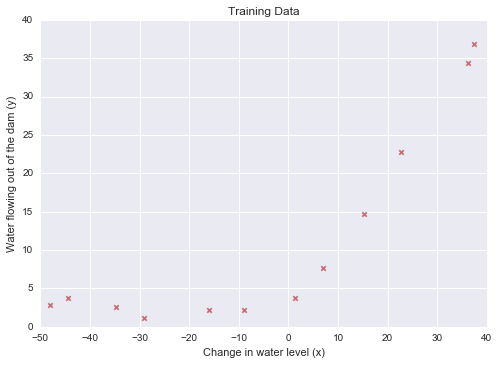

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
mpl.rcParams["figure.figsize"] = (12,6)

sns.set(color_codes=True)
sns.regplot(X,y, fit_reg=False, marker='x', color='r')
plt.ylim(0, 40)
plt.xlim(-50,40)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.title('Training Data')
plt.show()

    Plot reveals non-linear relationship

### Recall regularized linear regression cost function:

$$ J(\theta) = \frac{1}{2m}\left(\sum_{i=1}^m(h_{\theta}(x^{(i)}) - y^{(i)})^2\right) + \frac{\lambda}{2m}\left(\sum_{j=1}^n\theta^2\right) $$

### Regularized linear regression gradient:

for $j = 0$
$$ 
\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m (h_{\theta}(x^{(i)}) - y^{(i)})x_j^{(i)} 
$$ 

for $j \geq 1$

$$
\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m (h_{\theta}(x^{(i)}) - y^{(i)})x_j^{(i)} + \frac{\lambda}{m}\theta_j
$$

In [90]:
class LinearModel(object):
    '''
    Initializes a LinearModel object that takes as input the 
    data matrix `X`, the outcome vector `y` and optionally 
    the parameter vector `theta`.
    '''
    def __init__(self):
        self.X = None
        self.y = None
        self.X_poly = None
        self.J = [] # list for storing computed costs
        self.optimized_theta = None 
        self.mu = None
        self.sigma = None
        self.p = None
    
    def hypothesis(self, theta, X, y, add_bias = False):
        """
        Computes the hypothesis function for given parameter `theta`.
        """
        if add_bias:
            X = np.insert(X, 0, 1, axis=1) # Add add_bias/intercept 
        if type(theta) == list:
            theta = np.array(theta).reshape(len(theta),1) 
        else:
            theta = theta.reshape(X.shape[1],1)
        m = len(y)

        h = np.dot(X, theta) - y 

        return X, y, theta, h, m 
    
    def cost(self, theta, X, y, regularization=0, add_bias = False):
        '''
        Computes the cost for regularized linear regression 
        given parameter `theta`.
        
        returns: cost `J`
        '''
        X, y, theta, h, m = self.hypothesis(theta, X, y, add_bias)
        
        # compute cost
        J = 1/(2*m) * np.sum(np.square(h))
        
        # Regularization 
        theta_no_bias = theta[1:]         # exclude Bias term

        J += regularization/(2*m) * np.sum(np.square(theta_no_bias))

        return J
    
    def gradient(self, theta, X, y, regularization = 0, add_bias = False):
        """
        Computes Gradient for given parameter `theta`
        """
        X, y, theta, h, m = self.hypothesis(theta, X, y, add_bias)
        grad = 1/m * np.dot(X.transpose(), h)
        
        # Regularization without intercept term
        grad[1:] += regularization/m * theta[1:]

        return grad.flatten()
    
    def train(self, X, y, regularization=0, add_bias=False, 
              plot = True, p=1, disp=1):
        """
        Trains linear regression given regularization parameter lambda.
        
        Returns Coefficients and plots linear fit
        """
        from scipy.optimize import fmin_cg
        self.X = X
        self.y = y
        if p > 1:
            self.p = p
            X = self.polyFeatures(X, p)
            self.X_poly = X
        if add_bias:
            X = np.insert(X, 0, 1, axis=1) # Add bias/intercept 
            
        x0 = np.zeros((X.shape[1],1))
        self.optimized_theta = fmin_cg(self.cost, x0, args = (X, y, regularization), disp=disp, fprime = self.gradient, maxiter = 200)
        
        if plot:
            self.plot_fit(X, y)
        
        return self.optimized_theta
    
    def learningCurve(self, X, y, Xval, yval, regularization, add_bias=False, nb=True):
        """
        Generates the train and cross validation set errors needed 
        to plot a learning curve.
        
        returns the train and
        cross validation set errors for a learning curve. In particular, 
        it returns two vectors of the same length - error_train and 
        error_val. Then, error_train(i) contains the training error for
        i examples (and similarly for error_val(i)).
        """
        if add_bias:
            X = np.insert(X, 0, 1, axis=1)
            Xval = np.insert(Xval, 0, 1, axis=1)
        m = X.shape[0]
        error_train = np.zeros((m, 1))
        error_val = np.zeros((m, 1))
        
        for i in range(m):
            X_train = X[:i+1, :]
            y_train = y[:i+1]
            theta = self.train(X_train, y_train, regularization, disp=0, plot=False)
            error_train[i] = self.cost(theta,X_train, 
                                                     y_train)

            error_val[i] = self.cost(theta, Xval, yval)
            print("Train Error: %.4f\tCross Val Error: %.4f" % (error_train[i],
                                                                 error_val[i]))
            
        import matplotlib as mpl
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        sns.set(color_codes=True)
        if nb:
            %matplotlib inline
        
        
        plt.plot(range(1,m+1), error_train, label='Train')
        plt.plot(range(1,m+1), error_val, color='r', label='Cross Validation')
        plt.legend()
        plt.title('Learning curve for linear regression')
        plt.xlabel('Number of training examples')
        plt.ylabel('Error')
        
        plt.show()
        
    def polyFeatures(self, X, p, scaled=True):
        '''
        Takes a data matrix X (size m x 1) and
        maps each example into its polynomial features where
        X_poly(i, :) = [X(i) X(i).^2 X(i).^3 ...  X(i).^p];
    
        Returns scaled data matrix with polynomial features and its column
        wise means and standard deviations.
        '''

        X_poly = X 

        for i in range(2, p+1):
            X_poly = np.concatenate((X_poly, np.power(X,i)),
                                axis=1)
    
        
        if scaled:
            self.mu = np.mean(X_poly, axis=0)
            self.sigma = np.std(X_poly,axis=0)
            return (X_poly - self.mu)/self.sigma
            
    
        return X_poly
    
    def plot_fit(self, X, y, add_bias = False, 
                 title="Best Linear Fit", nb = True):
        import matplotlib as mpl
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        sns.set(color_codes=True)
        if nb:
            %matplotlib inline
        
        if not add_bias:
            X_no_intercept = X[:,1:]
        else:
            # confusing I know
            X_no_intercept = X 
            X = np.insert(X, 0, 1, axis=1) 
            
        theta = self.optimized_theta
        
        if X.shape[1] > 2:
            self.poly_plot()
            
            
        else: 
            sns.regplot(X_no_intercept, y, fit_reg=False, marker='x', color='r')
            plt.plot(X_no_intercept, np.dot(X,theta))
            plt.title("Best Linear Fit")
            plt.ylim(min(y) - 5, max(y) + 2)
            plt.xlim(min(X_no_intercept) - 2,max(X_no_intercept) + 2)
            plt.xlabel("Change in water level (x)")
            plt.ylabel('Water flowing out of the dam (y)')

            plt.show()
            
    def poly_plot(self):
        
        import matplotlib.pyplot as plt
        import seaborn as sns
    
        x = np.linspace(np.min(self.X) - 15,\
                            np.max(self.X) + 25,\
                            num=2500).transpose().reshape(2500,1)

        x_poly = self.polyFeatures(x, self.p, scaled=False)
        x_poly = (x_poly - self.mu) / self.sigma
        x_poly = np.insert(x_poly, 0, 1, axis=1)
    
        sns.set(color_codes=True)
        sns.regplot(self.X,self.y, fit_reg=False, marker='x', color='r')
        plt.plot(x, np.dot(x_poly,self.optimized_theta), '--')
        plt.xlabel('Change in water level (x)')
        plt.ylabel('Water flowing out of the dam (y)')
        plt.title('Polynomial Regression Fit')
        plt.show()
        
    def plot_data(self, X, y, title="Training Data", nb = True):
        import matplotlib as mpl
        import matplotlib.pyplot as plt
        import seaborn as sns
        if nb:
            %matplotlib inline
        mpl.rcParams["figure.figsize"] = (12,6)

        sns.set(color_codes=True)
        sns.regplot(X,y, fit_reg=False, marker='x', color='r')
        plt.ylim(min(y) - 2, max(y) + 2)
        plt.xlim(min(X) - 2,max(X) + 2)
        plt.xlabel('Change in water level (x)')
        plt.ylabel('Water flowing out of the dam (y)')
        plt.title(title)
        
        plt.show()

#### Initialize Model

In [91]:
lin_mod = LinearModel()

#### COmpute Cost for given parameters

In [92]:
lin_mod.cost([1,1], X, y, regularization=1, add_bias=True)

303.99319222026429

#### Compute Gradient for given parameters

In [93]:
lin_mod.gradient([1,1], X, y, regularization=1, add_bias=True)

array([ -15.30301567,  598.25074417])

#### Train Model for given regularization parameter (here lambda = 0)

Optimization terminated successfully.
         Current function value: 22.373906
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5


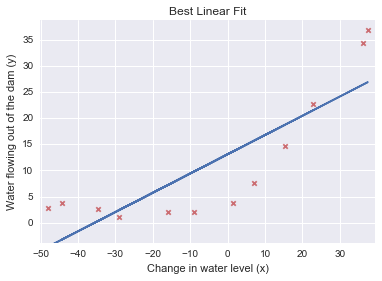

array([ 13.08790351,   0.36777923])

In [94]:
coeff = lin_mod.train(X, y, add_bias=True)
coeff

#### Plot Data Method

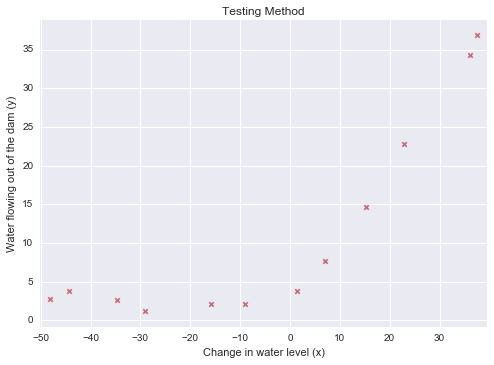

In [95]:
lin_mod.plot_data(X,y, title='Testing Method')

#### Plot fit method

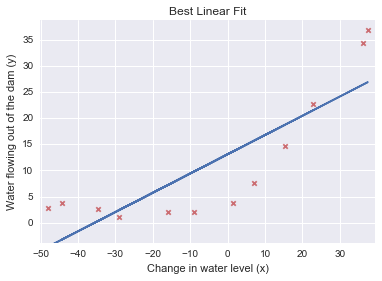

In [96]:
lin_mod.plot_fit(X, y, add_bias=True)

# Bias-variance

## Learning Curves

Train Error: 0.0000	Cross Val Error: 205.1211
Train Error: 0.0000	Cross Val Error: 110.3004
Train Error: 3.2866	Cross Val Error: 45.0102
Train Error: 2.8427	Cross Val Error: 48.3689
Train Error: 13.1540	Cross Val Error: 35.8651
Train Error: 19.4440	Cross Val Error: 33.8300
Train Error: 20.0985	Cross Val Error: 31.9710
Train Error: 18.1729	Cross Val Error: 30.8624
Train Error: 22.6094	Cross Val Error: 31.1360
Train Error: 23.2615	Cross Val Error: 28.9362
Train Error: 24.3172	Cross Val Error: 29.5514
Train Error: 22.3739	Cross Val Error: 29.4338


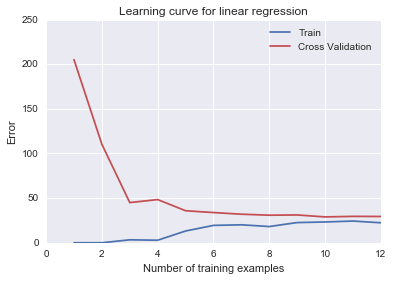

In [97]:
lin_mod.learningCurve(X, y, X_val, y_val, regularization=0, add_bias=True)

    [...] [One] can observe that both the train error and cross validation error are high when the number of training examples is increased. This reflects a high bias problem in the model – the linear regression model is too simple and is unable to fit our dataset well. In the next section, you will implement polynomial regression to fit a better model for this dataset.

## Polynomial Regression

In [98]:
def polyFeatures(X, p, scaled=True):
    '''
    Takes a data matrix X (size m x 1) and
    maps each example into its polynomial features where
    X_poly(i, :) = [X(i) X(i).^2 X(i).^3 ...  X(i).^p];
    
    Returns scaled data matrix with polynomial features and its column
    wise means and standard deviations.
    '''
    from sklearn.preprocessing import scale
    X_poly = np.zeros((len(X), p))
    X_poly = X 

    for i in range(2, p+1):
        X_poly = np.concatenate((X_poly, np.power(X,i)),
                                axis=1)
    
    mu, sigma = np.mean(X_poly, axis=0), np.std(X_poly, axis=0)
    
    if scaled:
        return (X_poly - mu)/np.std(X_poly,axis=0), mu, sigma 
    
    return X_poly

def poly_plot(X, mu, sigma, y, xmin, xmax, theta, p):
    x = np.linspace(xmin - 15,\
                            xmax + 25,\
                            num=2500).transpose().reshape(2500,1)

    x_poly = polyFeatures(x, p, scaled=False)
    x_poly = (x_poly - mu) / sigma
    x_poly = np.insert(x_poly, 0, 1, axis=1)
    
    
    #return np.dot(x_poly,theta)
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    sns.set(color_codes=True)
    sns.regplot(X,y, fit_reg=False, marker='x', color='r')
    plt.plot(x, np.dot(x_poly,theta), '--')
    plt.xlabel('Change in water level (x)')
    plt.ylabel('Water flowing out of the dam (y)')
    plt.title('Polynomial Regression Fit')
    plt.show()
    
    
X_poly, mu, sigma = polyFeatures(X,8, scaled=True)
    
poly_plot(X, mu, sigma, y, np.min(X), np.max(X), lin_mod.optimized_theta, 8)

### Overfitting: regularization (lambda) = 0

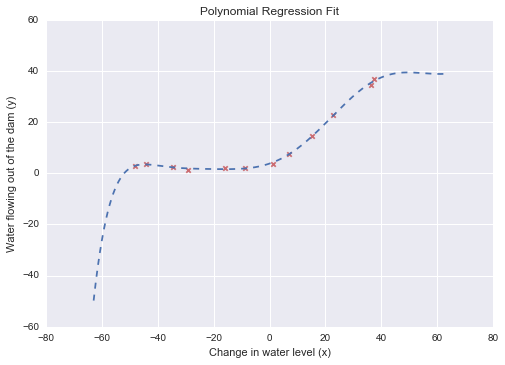

In [110]:
theta = lin_mod.train(X, y, add_bias=True, plot=False, p = 8, regularization=0)
lin_mod.poly_plot()

### Regularization: lambda = 1


Optimization terminated successfully.
         Current function value: 6.830463
         Iterations: 34
         Function evaluations: 62
         Gradient evaluations: 62


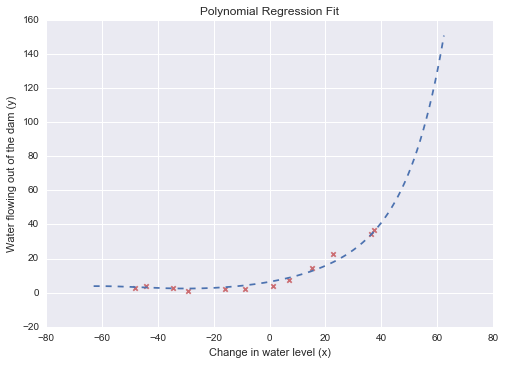

In [111]:
theta = lin_mod.train(X, y, add_bias=True, plot=False, p = 8, regularization=1)
lin_mod.poly_plot()

### Underfitting: lambda = 50

Optimization terminated successfully.
         Current function value: 58.192869
         Iterations: 16
         Function evaluations: 28
         Gradient evaluations: 28


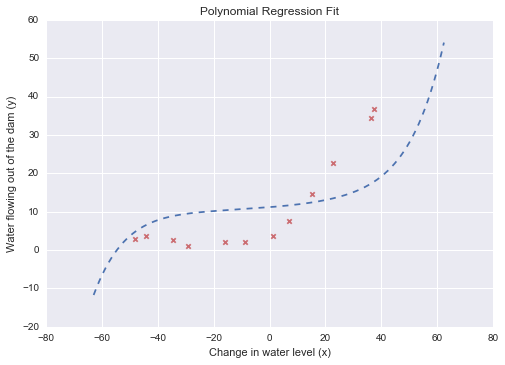

In [113]:
theta = lin_mod.train(X, y, add_bias=True, plot=False, p = 8, regularization=50)
lin_mod.poly_plot()